Install Required Libraries

In [1]:
import sys
!{sys.executable} -m pip install ipywidgets requests
!{sys.executable} -m pip install torch torchvision
!{sys.executable} -m pip install numpy pandas matplotlib tqdm pillow --quiet

  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/1e/db/4254e3eabe8020b458f1a747140d32277ec7a271daf1d235b70dc0b4e6e3/requests-2.32.5-py3-none-any.whl.metadata
  Obtaining dependency information for charset_normalizer<4,>=2 from https://files.pythonhosted.org/packages/3d/2d/1e5ed9dd3b3803994c155cd9aacb60c82c331bad84daf75bcb9c91b3295e/charset_normalizer-3.4.4-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for idna<4,>=2.5 from https://files.pythonhosted.org/packages/0e/61/66938bbb5fc52dbdf84594873d5b51fb1f7c7794e9c0f5bd885f30bc507b/idna-3.11-py3-none-any.whl.metadata
  Obtaining dependency information for urllib3<3,>=1.21.1 from https://files.pythonhosted.org/packages/6d/b9/4095b668ea3678bf6a0af005527f39de12fb026516fb3df17495a733b7f8/urllib3-2.6.2-py3-none-any.whl.metadata
  Obtaining dependency information for certifi>=2017.4.17 from https://files.pythonhosted.org/packages/70/7d/9bc192684cea499815ff478dfcdc13835ddf4013650

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Libraries

In [2]:
# Libraries for OS and Cloud
import os
import uuid
import shutil
import json
import copy
from datetime import datetime
import zipfile
import io
import requests
import random

In [3]:
# Libraries for Data Processing and Visualization
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

In [4]:
# Deep Learning Libraries
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)
from torchvision.datasets import ImageFolder

Define Functions for Loss and Accuracy Plot, Transformed Image Plot and Model Training

In [5]:
def plot_stuff(COST, ACC):
    """
    Plots training cost (loss) and validation accuracy on the same figure using two y-axes.
    
    Parameters:
    COST (list or array): Total training loss per iteration (or epoch)
    ACC (list or array): Validation accuracy per iteration (or epoch)
    """
    
    # Create a new figure and a primary axis (ax1)
    fig, ax1 = plt.subplots()
    
    # Plot training loss on the primary y-axis (left)
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('Iteration', color=color)            # Label for x-axis
    ax1.set_ylabel('Total Loss', color=color)           # Label for y-axis (left)
    ax1.tick_params(axis='y', labelcolor=color)         # Set y-axis tick color

    # Create a secondary y-axis (ax2) sharing the same x-axis
    ax2 = ax1.twinx()
    
    # Plot validation accuracy on the secondary y-axis (right)
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)             # Label for y-axis (right)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Adjust layout to prevent y-label clipping
    fig.tight_layout()
    
    # Display the combined plot
    plt.show()


In [6]:
def imshow_(inp, title=None):
    """
    Displays a tensor image after reversing normalization.
    
    Parameters:
    - inp (Tensor): Image tensor of shape [C, H, W], usually normalized.
    - title (str, optional): Title for the image display.
    """
    # Convert from [C, H, W] to [H, W, C] and to NumPy array
    inp = inp.permute(1, 2, 0).numpy()
    print("Image shape:", inp.shape)

    # Undo normalization (ImageNet mean and std)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean

    # Clip values to [0, 1] range for display
    inp = np.clip(inp, 0, 1)

    # Display image
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Short pause for GUI update
    plt.show()


In [7]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs, print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    
    n_test = len(val_dataset)
    accuracy_best = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    print("The first epoch should take several minutes")
    
    for epoch in tqdm(range(n_epochs)):
        loss_sublist = []
        for x, y in train_loader:
            
            x, y = x.to(device), y.to(device)
            model.train()
            
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f"Epochs {epoch + 1} done")
        schedular.step()
        
        loss_list.append(np.mean(loss_sublist))
        
        #validation
        model.eval()
        
        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
                
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        
        if accuracy > accuracy_best:
            accuracy_best = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            
        if print_:
            print("Learning rate:", optimizer.param_groups[0]['lr'])
            print(f"Validation loss (epoch {epoch + 1}): {np.mean(loss_sublist):.4f}")
            print(f"Validation accuracy (epoch {epoch + 1}): {accuracy:.4f}")
            
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


Image Processing and Load Data for Dataset Preparation

In [9]:
# Load Data for Dataset Preparation
# URL of the ZIP file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ExisQFol3hUHktTjm6a51w/final-project-stop-signs-1-2025-04-25-t-06-47-41-058-z.zip"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the zip file from the downloaded content
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall("not_stopandstop")  # Extract to a target folder
    print("Download and extraction complete.")
else:
    print("Failed to download file:", response.status_code)


Download and extraction complete.


In [10]:
# sets path
source_dir = "not_stopandstop/final-project-stop-signs-1-2025-04-25-t-06-47-41-058-z"  # folder containing images and annotation file
annotations_file = os.path.join(source_dir, "_annotations.json")  # update name if needed

In [11]:
# Load annotations
with open(annotations_file, "r") as f:
    annotations = json.load(f)

In [12]:
# Parameters
train_ratio = 0.9
output_dir = "dataset"  # Final output root directory


In [13]:
# Prepare label -> image list
label_to_images = {}

for filename, entry in annotations["annotations"].items():
    label = entry[0]["label"]
    label_to_images.setdefault(label, []).append(filename)

In [14]:
# Shuffle and split each class into training and validation sets
for label, image_list in label_to_images.items():
    random.shuffle(image_list)  # Shuffle the list of images to randomize the split
    
    # Calculate the number of training images (e.g., 90% of total)
    train_cutoff = int(len(image_list) * train_ratio)
    
    # Split the image list into training and validation sets
    train_images = image_list[:train_cutoff]
    val_images = image_list[train_cutoff:]

    # Loop over both splits: 'train' and 'val'
    for split, split_images in zip(["train", "val"], [train_images, val_images]):
        
        # Create the output directory for the current split and label
        # Example: dataset/train/not_stop or dataset/val/stop
        out_path = os.path.join(output_dir, split, label)
        os.makedirs(out_path, exist_ok=True)  # Create the directory if it doesn't exist

        # Copy each image from the source directory to the appropriate split folder
        for img_name in split_images:
            src = os.path.join(source_dir, img_name)  # Full path to the source image
            dst = os.path.join(out_path, img_name)    # Destination path
            shutil.copy2(src, dst)  # Copy the image (preserves metadata)

# Print completion message once all images are copied
print("Train/Val split complete.")


Train/Val split complete.


In [15]:
# Define a series of transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224,0.225]
    )
])

In [16]:
# Load datastes from the respective folders.
train_dataset = ImageFolder(root="dataset/train", transform=transform)
val_dataset = ImageFolder(root="dataset/val", transform=transform)

Image shape: (224, 224, 3)


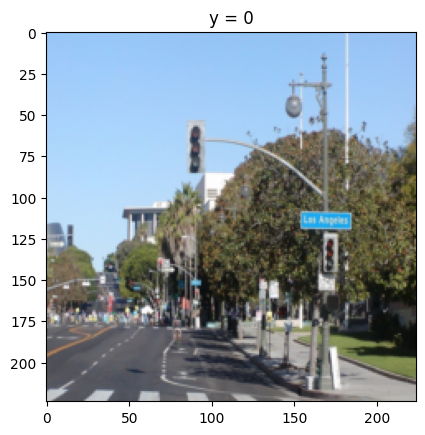

Image shape: (224, 224, 3)


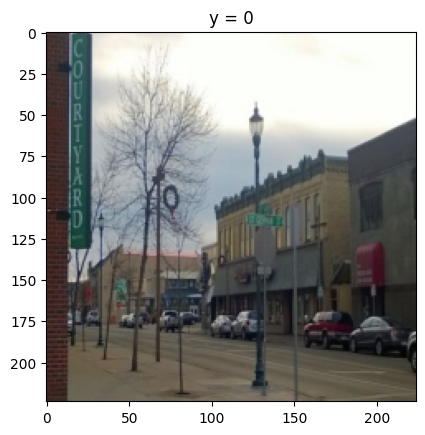

Image shape: (224, 224, 3)


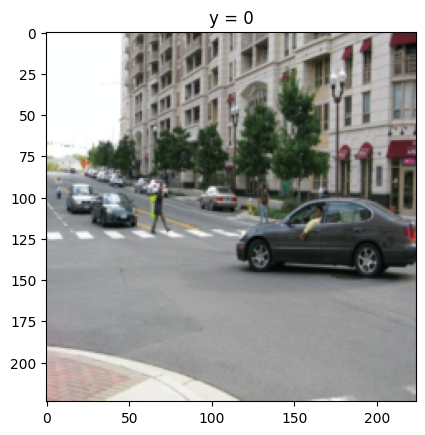

In [17]:
# Loop through the validation datasets and display the first 3 images.

i = 0
for x, y in val_dataset:
    imshow_(x, f"y = {y}")
    i += 1
    if i == 3:
        break

In [18]:
# Sets the number of Epochs and Batch size.
n_epochs = 10
batch_size = 32

In [19]:
# Set optimizer hyperparameters.
learning_rate = 0.000001
momentum = 0.9

In [20]:
# Enable learning rate scheduling.
lr_scheduler = True
base_lr = 0.001
max_lr = 0.01

Load Model and Train

In [21]:
# Set the parameter pretrained to True.
model = models.resnet18(pretrained=True)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Freeze all the parameters to prevent updates during training.
for param in model.parameters():
    param.requires_grad = False

In [23]:
# Find number of classes from the dataset.
n_classes = len(train_dataset.classes)
print(n_classes)

2


In [24]:
# Repalce the output layer to match the number of classes.
model.fc = nn.Linear(512, n_classes)

In [25]:
# Set device type.
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# Define the loss function for multi-class classification.
criterion = nn.CrossEntropyLoss()

In [27]:
# Create data loaders for training and validation.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1)

In [28]:
# Initialize the optimizer.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [29]:
if lr_scheduler:
    schedular = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=0.001,
        max_lr=0.01,
        step_size_up=5,
        mode="triangular2"
    )

In [30]:
# Start time tracking
start_datetime = datetime.now()
start_time = time.time()

# Train the model
accuracy_list, loss_list, model = train_model(
    model, train_loader, validation_loader, criterion, optimizer, n_epochs=n_epochs
)

# End time tracking
end_datetime = datetime.now()
elapsed_time = time.time() - start_time

# Print results
print("Training completed.")
print(f"Start Time     : {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End Time       : {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Elapsed Time   : {elapsed_time:.2f} seconds")


The first epoch should take several minutes


  0%|          | 0/10 [00:00<?, ?it/s]

Epochs 1 done


 10%|█         | 1/10 [00:18<02:46, 18.51s/it]

Learning rate: 0.002800000000000002
Validation loss (epoch 1): 0.6800
Validation accuracy (epoch 1): 0.5500
Epochs 2 done


 20%|██        | 2/10 [00:29<01:53, 14.20s/it]

Learning rate: 0.0046
Validation loss (epoch 2): 0.5300
Validation accuracy (epoch 2): 1.5000
Epochs 3 done


 30%|███       | 3/10 [00:41<01:30, 12.90s/it]

Learning rate: 0.006400000000000001
Validation loss (epoch 3): 0.3305
Validation accuracy (epoch 3): 2.4500
Epochs 4 done


 40%|████      | 4/10 [00:51<01:11, 11.98s/it]

Learning rate: 0.008199999999999999
Validation loss (epoch 4): 0.2537
Validation accuracy (epoch 4): 3.4000
Epochs 5 done


 50%|█████     | 5/10 [01:03<00:59, 11.92s/it]

Learning rate: 0.010000000000000002
Validation loss (epoch 5): 0.1729
Validation accuracy (epoch 5): 4.3500
Epochs 6 done


 60%|██████    | 6/10 [01:13<00:45, 11.37s/it]

Learning rate: 0.008199999999999999
Validation loss (epoch 6): 0.2049
Validation accuracy (epoch 6): 5.3000
Epochs 7 done


 70%|███████   | 7/10 [01:23<00:32, 10.92s/it]

Learning rate: 0.006400000000000001
Validation loss (epoch 7): 0.1824
Validation accuracy (epoch 7): 6.2000
Epochs 8 done


 80%|████████  | 8/10 [01:33<00:21, 10.62s/it]

Learning rate: 0.0046
Validation loss (epoch 8): 0.1077
Validation accuracy (epoch 8): 7.1500
Epochs 9 done


 90%|█████████ | 9/10 [01:43<00:10, 10.37s/it]

Learning rate: 0.002800000000000002
Validation loss (epoch 9): 0.1114
Validation accuracy (epoch 9): 8.1000
Epochs 10 done


100%|██████████| 10/10 [01:53<00:00, 11.35s/it]

Learning rate: 0.001
Validation loss (epoch 10): 0.0880
Validation accuracy (epoch 10): 9.0500
Training completed.
Start Time     : 2025-12-30 22:09:31
End Time       : 2025-12-30 22:11:25
Elapsed Time   : 113.71 seconds


In [31]:
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

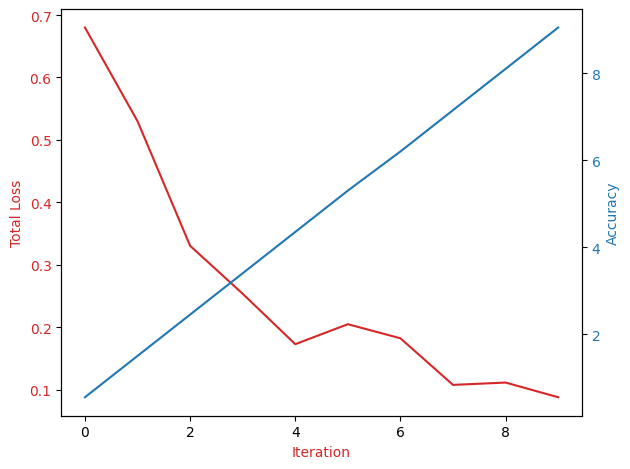

In [32]:
# Plot training loss and validation accuracy.
plot_stuff(loss_list, accuracy_list)

Test Model with any Uploaded Image

In [50]:
urls = [
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ko-rMe71oPApYpUj2urgFQ/stop-1.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/2oSHTMfHikZvnhKypHO9Uw/stop-2.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6GVQqlNsZ83-me4L9DzAIg/not-stop-1.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/47aCgskKGqJTYmIkvV6_mA/not-stop-2.jpeg"
]

os.makedirs("validation_images", exist_ok=True)

for i, url in enumerate(urls, start=1):
    response = requests.get(url, timeout=15)
    response.raise_for_status()  # 🚨 stops on 404 or other HTTP errors

    file_path = f"validation_images/image_{i}.jpg"
    with open(file_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {file_path} ({len(response.content)} bytes)")

print("All images downloaded correctly!")


Downloaded validation_images/image_1.jpg (806107 bytes)
Downloaded validation_images/image_2.jpg (284203 bytes)
Downloaded validation_images/image_3.jpg (1141135 bytes)
Downloaded validation_images/image_4.jpg (249163 bytes)
All images downloaded correctly!


In [51]:
# Load a trained model for inference.
class_names = ['not_stop', 'stop']
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("model.pt", map_location=torch.device('cpu')))
model.eval()

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
# Define the same image transformations used during training.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.2229, 0.224, 0.225])
])

In [55]:
# Apply transformations and add batch dimensions.
image_path = r"C:\Users\DELL\OneDrive\Desktop\resnet-image-classifier\validation_images\image_4.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

The image was classified as: not_stop


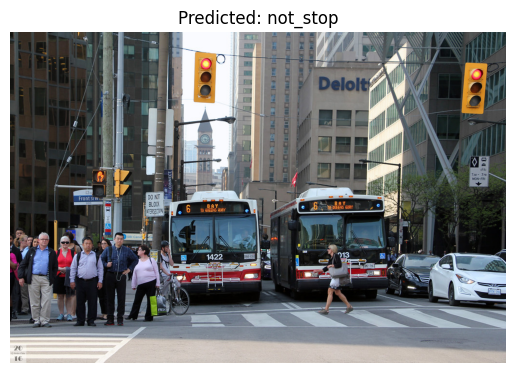

In [56]:
# Perform inference without tracking gradients.
with torch.no_grad():
    outputs = model(input_tensor)
    predicted_class = torch.argmax(outputs, dim=1).item()
    
print(f"The image was classified as: {class_names[predicted_class]}")

# Display results
plt.imshow(image)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()